In [ ]:
import sys

!{sys.executable} -m pip install \
    matplotlib \
    datasets \
    transformers[torch] \
    peft \
    scikit-learn \
    accelerate \
    bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 7.4 MB/s  0:00:01 eta 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 12.4 MB/s  0:00:01eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 5.2 MB/s  0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 556.4/556.4 kB 13.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 10.1 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 9.8 MB/s  0:00:066m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 5.8 MB/s  0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 6.9 MB/s  0:00:01m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 5.6 MB/s  0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 9.6 MB/s  0:00:05m0:00:01m0:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.5/803.5 kB 3.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 9.0 MB/

In [ ]:
import os
import sys

%cd /workspace/chatbot

sys.path.append(os.getcwd())
!ls



/workspace/chatbot
 app_gradio.ipynb			   model_evaluation.ipynb
 data					   models
 data_generating			   rag_evaluation.ipynb
 data_viz.ipynb				   src
 eval_rag_faithfulness_gemini_custom.csv  'train_models (1).ipynb'
 faithfulness_results.jsonl		   train_qwen2_3b.ipynb


# Qwen2 3b

In [ ]:
# Qwen2-3b

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

Map:   0%|          | 0/5629 [00:00<?, ? examples/s]

Map:   0%|          | 0/626 [00:00<?, ? examples/s]

Train size: 5629, Validation size: 626


config.json:   0%|          | 0.00/709 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

/tmp/ipykernel_1060/48489602.py:182: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Step,Training Loss,Validation Loss
200,0.942700,0.929648
400,0.840100,0.814700
600,0.755500,0.727774
800,0.659100,0.664976
1000,0.610700,0.629911
1200,0.609500,0.600579
1400,0.592900,0.578237
1600,0.553000,0.563250
1800,0.527200,0.551819
2000,0.531200,0.545088


✅ Loss saved to models/vi-qwen2-lora/training_loss.json


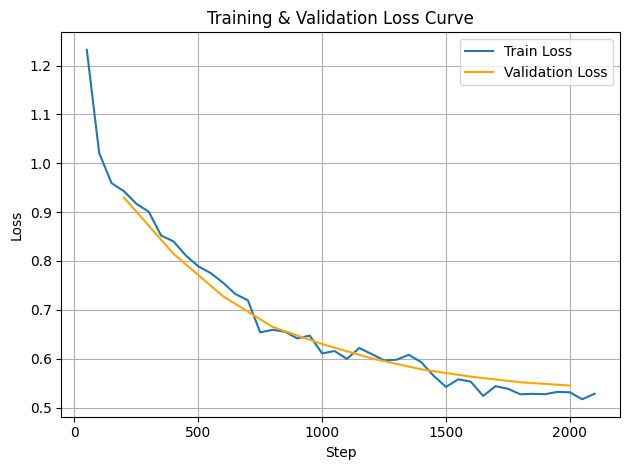

✅ Loss curve saved to models/vi-qwen2-lora/loss_curve.png
🎉 Fine-tuning hoàn tất! Model archived at models/vi-qwen2-lora.zip


In [ ]:
# =========================================
# 2️⃣ Import các thư viện
# =========================================
import os, json, shutil
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

import torch
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    Trainer, TrainingArguments,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig,
    TrainerCallback,
    EarlyStoppingCallback
)
from peft import LoraConfig, get_peft_model, TaskType

# =========================================
# 3️⃣ Load dữ
# =========================================
file_path = "data/merged_all.csv"
df = pd.read_csv(file_path)
df = df[['final_text', 'question', 'response']].dropna()

# train/validation split
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)
dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(val_df)
})

# =========================================
# 4️⃣ Tokenizer
# =========================================
model_name = "AITeamVN/Vi-Qwen2-3B-RAG"
tokenizer = AutoTokenizer.from_pretrained(model_name)
# tokenizer.pad_token = tokenizer.eos_token

# =========================================
# 5️⃣ Xây prompt và tokenization - FIXED
# =========================================
max_length = 1500
eos_id = tokenizer.eos_token_id

def tokenize_with_labels(example):
    # System prompt
    system_prompt = "### System: Hãy trả lời ngắn gọn. Nếu câu hỏi thiếu thông tin hoặc không liên quan, hãy từ chối trả lời.\n"

    # User prompt
    user_prompt = f"### Ngữ cảnh : {example['final_text']}\n### Câu hỏi : {example['question']}\n### Trả lời : "

    target = example['response']

    # Encode system và prompt
    system_ids = tokenizer.encode(system_prompt, truncation=True, max_length=100, add_special_tokens=False)
    prompt_ids = tokenizer.encode(user_prompt, truncation=True, max_length=max_length-400-len(system_ids), add_special_tokens=False)

    # Encode target, truncate trước, chừa 1 token cho EOS
    max_target_len = 400 - 1
    target_ids = tokenizer.encode(target, truncation=True, max_length=max_target_len, add_special_tokens=False)

    # Thêm EOS vào cuối target
    target_ids.append(eos_id)

    # Kết hợp tất cả
    input_ids = system_ids + prompt_ids + target_ids
    attention_mask = [1] * len(input_ids)

    # Mask system + prompt, target giữ nguyên
    labels = [-100] * (len(system_ids) + len(prompt_ids)) + target_ids

    # Padding đến max_length
    padding_length = max_length - len(input_ids)
    if padding_length > 0:
        input_ids += [tokenizer.pad_token_id] * padding_length
        attention_mask += [0] * padding_length
        labels += [-100] * padding_length

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

# =========================================
# 6️⃣ Tokenize dataset (KHÔNG DÙNG preprocess)
# =========================================
tokenized_train = dataset["train"].map(tokenize_with_labels, remove_columns=dataset["train"].column_names)
tokenized_val = dataset["validation"].map(tokenize_with_labels, remove_columns=dataset["validation"].column_names)

print(f"Train size: {len(tokenized_train)}, Validation size: {len(tokenized_val)}")

# =========================================
# 7️⃣ LoRA configuration
# =========================================
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q_proj", "v_proj"]
)

# =========================================
# 8️⃣ BitsAndBytes 4-bit config
# =========================================
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)

# =========================================
# 9️⃣ Load model + apply LoRA
# =========================================
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=bnb_config,
    trust_remote_code=True
)
model = get_peft_model(model, lora_config)

# =========================================
# 🔟 Data collator
# =========================================
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
    pad_to_multiple_of=8
)

# =========================================
# 1️⃣1️⃣ Callback ghi loss
# =========================================
class LossLoggerCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            if "loss" in logs:
                self.train_losses.append((state.global_step, logs["loss"]))
            if "eval_loss" in logs:
                self.eval_losses.append((state.global_step, logs["eval_loss"]))

loss_logger = LossLoggerCallback()
early_stop = EarlyStoppingCallback(early_stopping_patience=3)

# =========================================
# 1️⃣2️⃣ Training arguments
# =========================================
output_dir = "models/vi-qwen2-lora"
training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    learning_rate=3e-4,
    num_train_epochs=3,
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=200,
    save_strategy="steps",
    save_steps=200,
    fp16=True,
    optim="adamw_torch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

# =========================================
# 1️⃣3️⃣ Trainer
# =========================================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[loss_logger, early_stop]
)

# =========================================
# 1️⃣4️⃣ Train
# =========================================
trainer.train()

# =========================================
# 1️⃣5️⃣ Save model
# =========================================
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# =========================================
# 1️⃣6️⃣ Lưu loss và vẽ biểu đồ
# =========================================
loss_file = os.path.join(output_dir, "training_loss.json")
with open(loss_file, "w", encoding="utf-8") as f:
    json.dump({
        "train": loss_logger.train_losses,
        "validation": loss_logger.eval_losses
    }, f, ensure_ascii=False, indent=2)
print(f"✅ Loss saved to {loss_file}")

if loss_logger.train_losses:
    train_steps, train_losses = zip(*loss_logger.train_losses)
    plt.plot(train_steps, train_losses, label="Train Loss")
if loss_logger.eval_losses:
    val_steps, val_losses = zip(*loss_logger.eval_losses)
    plt.plot(val_steps, val_losses, label="Validation Loss", color="orange")

plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()

loss_plot_path = os.path.join(output_dir, "loss_curve.png")
plt.savefig(loss_plot_path)
plt.show()
print(f"✅ Loss curve saved to {loss_plot_path}")

# =========================================
# 1️⃣7️⃣ Zip model
# =========================================
shutil.make_archive(output_dir, 'zip', output_dir)
print(f"🎉 Fine-tuning hoàn tất! Model archived at {output_dir}.zip")


# LLama 3b

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/venv/main/lib/python3.12/site-packages/transformers/models/auto/tokenization_auto.py:1041: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

/venv/main/lib/python3.12/site-packages/transformers/models/auto/auto_factory.py:492: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

Map:   0%|          | 0/5629 [00:00<?, ? examples/s]

Map:   0%|          | 0/626 [00:00<?, ? examples/s]

/tmp/ipykernel_1307/2709085695.py:217: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009, 'pad_token_id': 128009}.


Step,Training Loss,Validation Loss
200,1.041800,1.016843
400,0.876900,0.846650
600,0.769400,0.739189
800,0.655100,0.672407
1000,0.603300,0.627813
1200,0.592800,0.589891
1400,0.568100,0.560310
1600,0.509800,0.542276
1800,0.488000,0.526034
2000,0.487400,0.517046


/venv/main/lib/python3.12/site-packages/peft/utils/other.py:1394: UserWarning: Unable to fetch remote file due to the following error 401 Client Error. (Request ID: Root=1-692e493b-755c450a5579ec7d746fbb7f;68b57977-eff1-4855-b8ca-e97efe9c6ca2)

Cannot access gated repo for url https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct/resolve/main/config.json.
Access to model meta-llama/Llama-3.2-3B-Instruct is restricted. You must have access to it and be authenticated to access it. Please log in. - silently ignoring the lookup for the file config.json in meta-llama/Llama-3.2-3B-Instruct.
  warnings.warn(
/venv/main/lib/python3.12/site-packages/peft/utils/save_and_load.py:295: UserWarning: Could not find a config file in meta-llama/Llama-3.2-3B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(
/venv/main/lib/python3.12/site-packages/peft/utils/other.py:1394: UserWarning: Unable to fetch remote file due to the following error 401 Client Error. (Request ID: Root

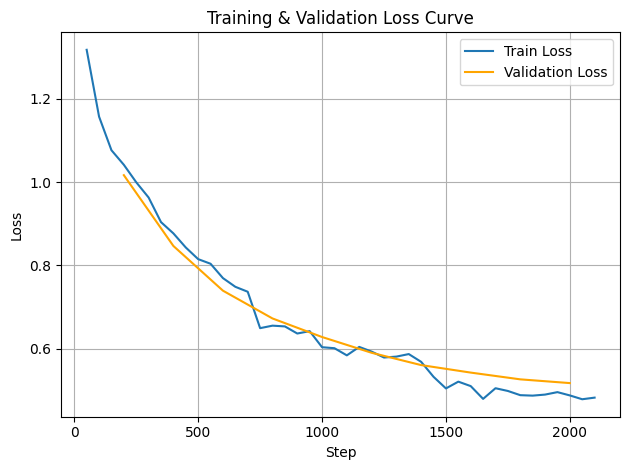

'/workspace/chatbot/models/llama3-3b-lora.zip'

In [ ]:
# =========================================
# 2️⃣ Import các thư viện
# =========================================
import os, json, shutil
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

import torch
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    Trainer, TrainingArguments,
    BitsAndBytesConfig,
    DataCollatorForLanguageModeling,
    TrainerCallback,
    EarlyStoppingCallback
)
from peft import LoraConfig, get_peft_model, TaskType


# =========================================
# 3️⃣ Load dữ
# =========================================
file_path = "data/merged_all.csv"
df = pd.read_csv(file_path)
df = df[['final_text', 'question', 'response']].dropna()

train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)
dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(val_df)
})


# =========================================
# 4️⃣ Load LLaMA tokenizer + model
# =========================================
model_name = "meta-llama/Llama-3.2-3B-Instruct"
hf_token = HF_TOKEN

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    use_auth_token=hf_token
)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# load model 4-bit
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=bnb_config,
    low_cpu_mem_usage=True,
    use_auth_token=hf_token,
)


# =========================================
# 5️⃣ Xây prompt + tokenize (GIỮ Y NGUYÊN LOGIC CỦA BẠN)
# =========================================
max_length = 1500
eos_id = tokenizer.eos_token_id

def tokenize_with_labels(example):
    # System prompt
    system_prompt = (
        "### System: Hãy trả lời ngắn gọn. Nếu câu hỏi thiếu thông tin hoặc "
        "không liên quan, hãy từ chối trả lời.\n"
    )

    # User prompt
    user_prompt = (
        f"### Ngữ cảnh : {example['final_text']}\n"
        f"### Câu hỏi : {example['question']}\n"
        f"### Trả lời : "
    )

    target = example["response"]

    # Encode
    system_ids = tokenizer.encode(system_prompt, truncation=True, max_length=100, add_special_tokens=False)
    prompt_ids = tokenizer.encode(
        user_prompt,
        truncation=True,
        max_length=max_length - 400 - len(system_ids),
        add_special_tokens=False
    )

    max_target_len = 400 - 1
    target_ids = tokenizer.encode(
        target,
        truncation=True,
        max_length=max_target_len,
        add_special_tokens=False
    )

    # add EOS
    target_ids.append(eos_id)

    # Combine
    input_ids = system_ids + prompt_ids + target_ids
    attention_mask = [1] * len(input_ids)

    # Mask: system + prompt = -100
    labels = [-100] * (len(system_ids) + len(prompt_ids)) + target_ids

    # Padding
    padding_length = max_length - len(input_ids)
    if padding_length > 0:
        input_ids += [tokenizer.pad_token_id] * padding_length
        attention_mask += [0] * padding_length
        labels += [-100] * padding_length

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels,
    }


# =========================================
# 6️⃣ Tokenize dataset
# =========================================
tokenized_train = dataset["train"].map(
    tokenize_with_labels,
    remove_columns=dataset["train"].column_names
)

tokenized_val = dataset["validation"].map(
    tokenize_with_labels,
    remove_columns=dataset["validation"].column_names
)


# =========================================
# 7️⃣ LoRA cấu hình
# =========================================
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q_proj", "v_proj"]
)

model = get_peft_model(model, lora_config)


# =========================================
# 8️⃣ Collator
# =========================================
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
    pad_to_multiple_of=8
)


# =========================================
# 9️⃣ Callback
# =========================================
class LossLoggerCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            if "loss" in logs:
                self.train_losses.append((state.global_step, logs["loss"]))
            if "eval_loss" in logs:
                self.eval_losses.append((state.global_step, logs["eval_loss"]))


loss_logger = LossLoggerCallback()
early_stop = EarlyStoppingCallback(early_stopping_patience=3)


# =========================================
# 🔟 Training arguments
# =========================================
output_dir = "models/llama3-3b-lora"

training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    learning_rate=3e-4,
    num_train_epochs=3,
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=200,
    save_strategy="steps",
    save_steps=200,
    bf16=True,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",
)


# =========================================
# 1️⃣1️⃣ Trainer
# =========================================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[loss_logger, early_stop]
)


# =========================================
# 1️⃣2️⃣ Train
# =========================================
trainer.train()


# =========================================
# 1️⃣3️⃣ Save model
# =========================================
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


# =========================================
# 1️⃣4️⃣ Save & plot loss
# =========================================
loss_file = os.path.join(output_dir, "training_loss.json")
with open(loss_file, "w", encoding="utf-8") as f:
    json.dump(
        {"train": loss_logger.train_losses, "validation": loss_logger.eval_losses},
        f, indent=2, ensure_ascii=False
    )

if loss_logger.train_losses:
    train_steps, train_losses = zip(*loss_logger.train_losses)
    plt.plot(train_steps, train_losses, label="Train Loss")

if loss_logger.eval_losses:
    steps, val_losses = zip(*loss_logger.eval_losses)
    plt.plot(steps, val_losses, label="Validation Loss", color="orange")

plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()

loss_plot_path = os.path.join(output_dir, "loss_curve.png")
plt.savefig(loss_plot_path)
plt.show()

# zip
shutil.make_archive(output_dir, "zip", output_dir)


# Qwen2 7b

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

Map:   0%|          | 0/5629 [00:00<?, ? examples/s]

Map:   0%|          | 0/626 [00:00<?, ? examples/s]

Train size: 5629, Validation size: 626


config.json:   0%|          | 0.00/709 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.88G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.33G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

/tmp/ipykernel_890/1890510119.py:182: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


Step,Training Loss,Validation Loss
200,0.855100,0.835684
400,0.721100,0.694138
600,0.628500,0.609110
800,0.534800,0.553530
1000,0.497600,0.519502
1200,0.487800,0.489162
1400,0.472400,0.465771
1600,0.421300,0.451264
1800,0.399000,0.439435
2000,0.401500,0.432126


✅ Loss saved to models/qwen2-7b/training_loss.json


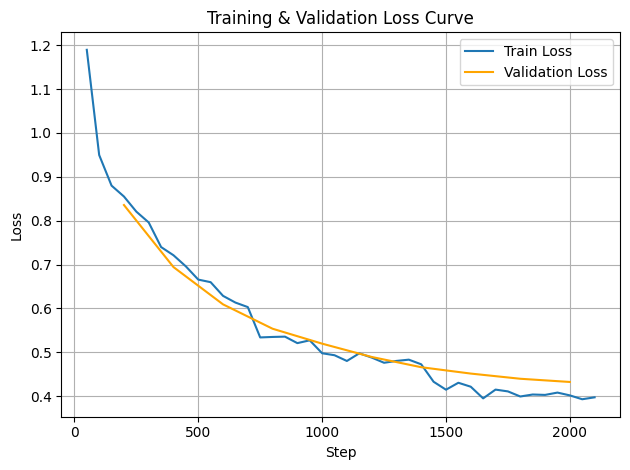

✅ Loss curve saved to models/qwen2-7b/loss_curve.png
🎉 Fine-tuning hoàn tất! Model archived at models/qwen2-7b.zip


In [ ]:
# =========================================
# 2️⃣ Import các thư viện
# =========================================
import os, json, shutil
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

import torch
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    Trainer, TrainingArguments,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig,
    TrainerCallback,
    EarlyStoppingCallback
)
from peft import LoraConfig, get_peft_model, TaskType

# =========================================
# 3️⃣ Load dữ
# =========================================
file_path = "data/merged_all.csv"
df = pd.read_csv(file_path)
df = df[['final_text', 'question', 'response']].dropna()

# train/validation split
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)
dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(val_df)
})

# =========================================
# 4️⃣ Tokenizer
# =========================================
model_name = "AITeamVN/Vi-Qwen2-7B-RAG"
tokenizer = AutoTokenizer.from_pretrained(model_name)
# tokenizer.pad_token = tokenizer.eos_token

# =========================================
# 5️⃣ Xây prompt và tokenization - FIXED
# =========================================
max_length = 1500
eos_id = tokenizer.eos_token_id

def tokenize_with_labels(example):
    # System prompt
    system_prompt = "### System: Hãy trả lời ngắn gọn. Nếu câu hỏi thiếu thông tin hoặc không liên quan, hãy từ chối trả lời.\n"

    # User prompt
    user_prompt = f"### Ngữ cảnh : {example['final_text']}\n### Câu hỏi : {example['question']}\n### Trả lời : "

    target = example['response']

    # Encode system và prompt
    system_ids = tokenizer.encode(system_prompt, truncation=True, max_length=100, add_special_tokens=False)
    prompt_ids = tokenizer.encode(user_prompt, truncation=True, max_length=max_length-400-len(system_ids), add_special_tokens=False)

    # Encode target, truncate trước, chừa 1 token cho EOS
    max_target_len = 400 - 1
    target_ids = tokenizer.encode(target, truncation=True, max_length=max_target_len, add_special_tokens=False)

    # Thêm EOS vào cuối target
    target_ids.append(eos_id)

    # Kết hợp tất cả
    input_ids = system_ids + prompt_ids + target_ids
    attention_mask = [1] * len(input_ids)

    # Mask system + prompt, target giữ nguyên
    labels = [-100] * (len(system_ids) + len(prompt_ids)) + target_ids

    # Padding đến max_length
    padding_length = max_length - len(input_ids)
    if padding_length > 0:
        input_ids += [tokenizer.pad_token_id] * padding_length
        attention_mask += [0] * padding_length
        labels += [-100] * padding_length

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

# =========================================
# 6️⃣ Tokenize dataset (KHÔNG DÙNG preprocess)
# =========================================
tokenized_train = dataset["train"].map(tokenize_with_labels, remove_columns=dataset["train"].column_names)
tokenized_val = dataset["validation"].map(tokenize_with_labels, remove_columns=dataset["validation"].column_names)

print(f"Train size: {len(tokenized_train)}, Validation size: {len(tokenized_val)}")

# =========================================
# 7️⃣ LoRA configuration
# =========================================
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q_proj", "v_proj"]
)

# =========================================
# 8️⃣ BitsAndBytes 4-bit config
# =========================================
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)

# =========================================
# 9️⃣ Load model + apply LoRA
# =========================================
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=bnb_config,
    trust_remote_code=True
)
model = get_peft_model(model, lora_config)

# =========================================
# 🔟 Data collator
# =========================================
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
    pad_to_multiple_of=8
)

# =========================================
# 1️⃣1️⃣ Callback ghi loss
# =========================================
class LossLoggerCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            if "loss" in logs:
                self.train_losses.append((state.global_step, logs["loss"]))
            if "eval_loss" in logs:
                self.eval_losses.append((state.global_step, logs["eval_loss"]))

loss_logger = LossLoggerCallback()
early_stop = EarlyStoppingCallback(early_stopping_patience=3)

# =========================================
# 1️⃣2️⃣ Training arguments
# =========================================
output_dir = "models/qwen2-7b"
training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    learning_rate=3e-4,
    num_train_epochs=3,
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=200,
    save_strategy="steps",
    save_steps=200,
    fp16=True,
    optim="adamw_torch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none"
)

# =========================================
# 1️⃣3️⃣ Trainer
# =========================================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[loss_logger, early_stop]
)

# =========================================
# 1️⃣4️⃣ Train
# =========================================
trainer.train()

# =========================================
# 1️⃣5️⃣ Save model
# =========================================
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# =========================================
# 1️⃣6️⃣ Lưu loss và vẽ biểu đồ
# =========================================
loss_file = os.path.join(output_dir, "training_loss.json")
with open(loss_file, "w", encoding="utf-8") as f:
    json.dump({
        "train": loss_logger.train_losses,
        "validation": loss_logger.eval_losses
    }, f, ensure_ascii=False, indent=2)
print(f"✅ Loss saved to {loss_file}")

if loss_logger.train_losses:
    train_steps, train_losses = zip(*loss_logger.train_losses)
    plt.plot(train_steps, train_losses, label="Train Loss")
if loss_logger.eval_losses:
    val_steps, val_losses = zip(*loss_logger.eval_losses)
    plt.plot(val_steps, val_losses, label="Validation Loss", color="orange")

plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()

loss_plot_path = os.path.join(output_dir, "loss_curve.png")
plt.savefig(loss_plot_path)
plt.show()
print(f"✅ Loss curve saved to {loss_plot_path}")

# =========================================
# 1️⃣7️⃣ Zip model
# =========================================
shutil.make_archive(output_dir, 'zip', output_dir)
print(f"🎉 Fine-tuning hoàn tất! Model archived at {output_dir}.zip")
